# Testing Python MINIMOD against GAMS MINIMOD using Cameroon Data

GAMS code comes from [Cameroon_maxvarobust2.gms](robustness_data/Cameroon_maxvarobust2.gms)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import pandas as pd
import os

from minimod import MonteCarloMinimod, Minimod


## Getting the Data Ready

In [144]:
data = "/home/lordflaron/Documents/GAMS-Python/Monte Carlo/robustness_data/"


df_costs = (
    pd.read_csv(data + 'cost_data.csv')
    .reset_index()
    .rename({'region' : 'space'}, axis=1)
    .assign(intervention = lambda df: df['intervention'].str.lower())
    .set_index(['intervention', 'space', 'time'])
    )

df_eff_coverage = (
    pd.read_csv(data +"coverage_robust_data.csv")
    .replace(to_replace={'north' : 'North', 'south' : 'South', 'cities' : 'Cities'})
    .assign(intervention = lambda df: df['intervention'].str.lower())
    .set_index(['intervention', 'space', 'time'])
    )

df_pop = (
    pd.read_excel(data + "data_in_gms_code/Age-group_pop_2015data.xlsx", sheet_name='6-59mos', header=2)
    .loc[lambda df: df['Time'].isin(range(1,11)), ['Time', 'North', 'South', 'Cities']]
    .set_index(['Time'])
    .stack()
    .to_frame()
    .reset_index()
    .rename({'Time': 'time', 'level_1' : 'space', 0 : 'population'}, axis=1)
    .set_index(['space', 'time'])    
)


In [145]:

def data_revision(ben_data, 
                  intervention_to_replace,
                  intervention_new,
                  time_to_replace,
                  region_to_replace):
    
    # Merge population data and benefits data at specified 
    # intervention and time period

    revised_values = ben_data.loc[(intervention_new, region_to_replace, time_to_replace), ['benefit_mean', 'benefit_sd']].values
    
    df = ben_data.copy(deep=True)
    # Now get data that will be replaced   

    df.loc[(intervention_to_replace, 
                  region_to_replace, 
                  time_to_replace), ['benefit_mean', 'benefit_sd']] = revised_values
    
    print(f"Done with {intervention_to_replace}")

    return df

def observation_revision(ben_data, 
                         values_to_replace,
                         intervention_to_replace,
                         region_to_replace,
                         time_to_replace,
                         pop_data = df_pop
                         ):
    
    df = ben_data.copy(deep=True)

    print(df.loc[(intervention_to_replace, region_to_replace, time_to_replace), 
           ['benefit_mean', 'benefit_sd']])

    print(pop_data.loc[(region_to_replace, time_to_replace)].values)
    
    df.loc[(intervention_to_replace, region_to_replace, time_to_replace), 
           ['benefit_mean', 'benefit_sd']] = \
               values_to_replace*pop_data.loc[(region_to_replace, time_to_replace)].values
    
    print(f"Changed {intervention_to_replace} to {values_to_replace*pop_data.loc[(region_to_replace, time_to_replace)].values} in {region_to_replace}")
    
    return df

def pre_draw_revision(data, intervention, int1 = None, int2 = None):

    if int1 is None:
        data.loc[(int2, slice(None), [1,2,3])] = 0
        return data
    if int2 is None:
        data.loc[(int1, slice(None), [4,5,6,7,8,9,10])] = 0
        return data

    df_2 = data[['benefit_mean', 'benefit_sd']].loc[(int1, slice(None), [1,2,3])]
    df_3 = data[['benefit_mean', 'benefit_sd']].loc[(int2, slice(None), [4,5,6,7,8,9,10])]

    if df_2.empty or df_3.empty:
        raise Exception(f"With {intervention}, {int1}, {int2}, One of the dataframes is empty.")
    

    # Append df_2 and df_3
    print(f"Using {int1} with {int2} for {intervention}...")
    
    new_df = df_2.append(df_3).rename({int1: intervention, int2:intervention})
    
    data.loc[(intervention, slice(None), slice(None)), ['benefit_mean', 'benefit_sd']] = new_df
    
    return data


In [147]:
## Now we make all the changes that were in the GAMS file.

new_benefits_df = (
    df_eff_coverage
    .pipe(data_revision, 
          intervention_to_replace = 'fortoil',
          intervention_new = 'dwoil',
          time_to_replace = 1,
          region_to_replace = slice(None))
    .pipe(data_revision,
          intervention_to_replace = 'capoil',
          intervention_new = 'capdwoil',
          time_to_replace = 1,
          region_to_replace = slice(None))
    .pipe(data_revision,
          intervention_to_replace = 'oilcube',
          intervention_new = 'capdwoil',
          time_to_replace = 1,
          region_to_replace = slice(None))
    .pipe(data_revision,
          intervention_to_replace = 'capoilcube',
          intervention_new = 'capdwoilcube',
          time_to_replace = 1,
          region_to_replace = slice(None))
    .pipe(data_revision,
          intervention_to_replace = 'capoilmaize',
          intervention_new = 'capdwoilmaize',
          time_to_replace = 1,
          region_to_replace = slice(None))
    .pipe(data_revision,
          intervention_to_replace = 'oilmaize',
          intervention_new = 'dwoilmaize',
          time_to_replace = 1,
          region_to_replace = slice(None))
    .pipe(data_revision,
          intervention_to_replace = 'oilcubemaize',
          intervention_new = 'dwoilcubemaize',
          time_to_replace = 1,
          region_to_replace = slice(None))
    .pipe(data_revision,
          intervention_to_replace = 'capoilcubemaize',
          intervention_new = 'capdwoilcubemaize',
          time_to_replace = 1,
          region_to_replace = slice(None))
    .pipe(observation_revision,
        values_to_replace = [0.188647039,0.056720184],
        intervention_to_replace = 'fortoil',
        region_to_replace = 'South',
        time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.184657986,0.051138841],
          intervention_to_replace = 'fortoil',
          region_to_replace = 'North',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.361048462,0.052177091],
          intervention_to_replace = 'fortoil',
          region_to_replace = 'Cities',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.271910918,0.03636394],
          intervention_to_replace = 'capoil',
          region_to_replace = 'South',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.552711992,0.043181427],
          intervention_to_replace = 'capoil',
          region_to_replace = 'North',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.429750048,0.027707883],
          intervention_to_replace = 'capoil',
          region_to_replace = 'Cities',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.317578384,0.041965529],
          intervention_to_replace = 'oilcube',
          region_to_replace = 'South',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.452445346,0.062957324],
          intervention_to_replace = 'oilcube',
          region_to_replace = 'North',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.460061855,0.034025083],
          intervention_to_replace = 'oilcube',
          region_to_replace = 'Cities',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.335812702,0.335812702],
          intervention_to_replace = 'capoilcube',
          region_to_replace = 'South',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.66038935,0.66038935],
          intervention_to_replace = 'capoilcube',
          region_to_replace = 'North',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.481598393,0.481598393],
          intervention_to_replace = 'capoilcube',
          region_to_replace = 'Cities',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.281736205,0.281736205],
          intervention_to_replace = 'capoilmaize',
          region_to_replace = 'South',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.449118915,0.449118915],
          intervention_to_replace = 'capoilmaize',
          region_to_replace = 'North',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.381499444,0.381499444],
          intervention_to_replace = 'capoilmaize',
          region_to_replace = 'Cities',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.193206296,0.039506241],
          intervention_to_replace = 'oilmaize',
          region_to_replace = 'South',
          time_to_replace = 2
          )
    .pipe(observation_revision,
          values_to_replace = [0.298684737,0.044670404],
          intervention_to_replace = 'oilmaize',
          region_to_replace = 'North',
          time_to_replace = 2
          )
    .pipe(observation_revision,
          values_to_replace = [0.314661303,0.031472923],
          intervention_to_replace = 'oilmaize',
          region_to_replace = 'Cities',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.281736205,0.038565253],
          intervention_to_replace = 'oilcubemaize',
          region_to_replace = 'South',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace= [0.449118915,0.046413903],
          intervention_to_replace = 'oilcubemaize',
          region_to_replace = 'North',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.381499444,0.033349636],
          intervention_to_replace = 'oilcubemaize',
          region_to_replace = 'Cities',
          time_to_replace=2)
    .pipe(observation_revision,
          values_to_replace= [0.331342794,0.032749485],
          intervention_to_replace= 'capoilcubemaize',
          region_to_replace= 'South',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.662643196,0.040875425],
          intervention_to_replace = 'capoilcubemaize',
          region_to_replace = 'North',
          time_to_replace = 2)
    .pipe(observation_revision,
          values_to_replace = [0.471177607,0.02437671],
          intervention_to_replace = 'capoilcubemaize',
          region_to_replace = 'Cities',
          time_to_replace = 2)
)




Done with fortoil
Done with capoil
Done with oilcube
Done with capoilcube
Done with capoilmaize
Done with oilmaize
Done with oilcubemaize
Done with capoilcubemaize
benefit_mean    293115.33
benefit_sd       72021.20
Name: (fortoil, South, 2), dtype: float64
[1408452.5]
Changed fortoil to [265700.39369715  79887.68495526] in South
benefit_mean    322380.44
benefit_sd       65731.02
Name: (fortoil, North, 2), dtype: float64
[1280227.5]
Changed fortoil to [236404.23177181  65469.35056633] in North
benefit_mean    244496.52
benefit_sd       24505.18
Name: (fortoil, Cities, 2), dtype: float64
[593648.5]
Changed fortoil to [214335.87789361  30974.85180651] in Cities
benefit_mean    408332.09
benefit_sd       50527.87
Name: (capoil, South, 2), dtype: float64
[1408452.5]
Changed capoil to [382973.61223439  51216.88220285] in South
benefit_mean    747709.48
benefit_sd       55915.19
Name: (capoil, North, 2), dtype: float64
[1280227.5]
Changed capoil to [707597.09173818  55282.05033464] in North

In [161]:
# Now we put together with costs

df_ready = (
    new_benefits_df
    .merge(df_costs, left_index = True, right_index = True)
    .pipe(pre_draw_revision,
    intervention = 'fortcube',
    int2 = 'fortcube')
    .pipe(pre_draw_revision,
    intervention = 'maize',
    int2 = 'maize')
    .pipe(pre_draw_revision,
    intervention = 'oilcube',
    int1 = 'fortoil',
    int2 = 'oilcube')
    .pipe(pre_draw_revision,
    intervention = 'oilmaize',
    int1 = 'fortoil',
    int2 = 'oilmaize')
    .pipe(pre_draw_revision,
    intervention = 'cubemaize',
    int2 = 'cubemaize')
    .pipe(pre_draw_revision,
    intervention = 'oilcubemaize',
    int1 = 'fortoil',
    int2 = 'oilcubemaize')
    .pipe(pre_draw_revision,
    intervention = 'capcube',
    int1 = 'capsules',
    int2 = 'capcube')
    .pipe(pre_draw_revision,
    intervention = 'capmaize',
    int1 = 'capsules',
    int2 = 'capmaize')
    .pipe(pre_draw_revision,
    intervention = 'dwcube',
    int1 = 'deworming',
    int2 = 'dwcube')
    .pipe(pre_draw_revision,
    intervention = 'dwmaize',
    int1 = 'deworming',
    int2 = 'dwmaize')
    .pipe(pre_draw_revision,
    intervention = 'mnpcube',
    int1 = 'mnp',
    int2 = 'mnpcube')
    .pipe(pre_draw_revision,
    intervention = 'mnpmaize',
    int1 = 'mnp',
    int2 = 'mnpmaize')
    .pipe(pre_draw_revision,
    intervention = 'cubecdti',
    int1 = 'cdti',
    int2 = 'cubecdti'
    )
    .pipe(pre_draw_revision,
    intervention = 'maizecdti',
    int1 = 'cdti',
    int2 = 'maizecdti')
    .pipe(pre_draw_revision,
    intervention = 'cubehf',
    int1 = 'hf',
    int2 = 'cubehf')
    .pipe(pre_draw_revision,
    intervention = 'cubebcc',
    int1 = 'bcc',
    int2 = 'cubebcc')
    .pipe(pre_draw_revision,
    intervention = 'maizebcc',
    int1 = 'bcc',
    int2 = 'maizebcc')
    .pipe(pre_draw_revision,
    intervention = 'capoilcube',
    int1 = 'capoil',
    int2 = 'capoilcube')
    .pipe(pre_draw_revision,
    intervention = "dwoilcube",
    int1 = "dwoil",
    int2 = "dwoilcube")
    .pipe(pre_draw_revision,
    intervention = "mnpoilcube",
    int1 = "mnpoil",
    int2 = "mnpoilcube")
    .pipe(pre_draw_revision,
    intervention = "capdwcube",
    int1 = "capdw",
    int2 = "capdwcube")
    .pipe(pre_draw_revision,
    intervention = "capdwmaize",
    int1 = "capdw",
    int2 = "capdwmaize")
    .pipe(pre_draw_revision,
    intervention = "capmnpcube",
    int1 = "capmnp",
    int2 = "capmnpcube")
    .pipe(pre_draw_revision,
    intervention = "capmnpmaize",
    int1 = "capmnp",
    int2 = "capmnpmaize")
    .pipe(pre_draw_revision,
    intervention = "capoilmaize",
    int1 = "capoil",
    int2 = "capoilmaize")
    .pipe(pre_draw_revision,
    intervention = "dwoilmaize",
    int1 = "dwoil",
    int2 = "dwoilmaize")
    .pipe(pre_draw_revision,
    intervention = "oilmnpmaize",
    int1 = "mnpoil",
    int2 = "oilmnpmaize")
    .pipe(pre_draw_revision,
    intervention = "capcubemaize",
    int1 = "capsules",
    int2 = "capcubemaize")
    .pipe(pre_draw_revision,
    intervention = "dwcubemaize",
    int1 = "deworming",
    int2 = "dwcubemaize")
    .pipe(pre_draw_revision,
    intervention = "cubemnpmaize",
    int1 = "mnp",
    int2 = "cubemnpmaize")
    .pipe(pre_draw_revision,
    intervention = "oilcubecdti",
    int1 = "oilcdti",
    int2 = "oilcubecdti")
    .pipe(pre_draw_revision,
    intervention = "oilmaizecdti",
    int1 = "oilcdti",
    int2 = "oilmaizecdti")
    .pipe(pre_draw_revision,
    intervention = "cubemaizecdti",
    int1 = "cdti",
    int2 = "cubemaizecdti")
    .pipe(pre_draw_revision,
    intervention = "oilcubehf",
    int1 = "oilhf",
    int2 = "oilcubehf")
    .pipe(pre_draw_revision,
    intervention = "oilmaizehf",
    int1 = "oilhf",
    int2 = "oilmaizehf")
    .pipe(pre_draw_revision,
    intervention = "cubemaizehf",
    int1 = "hf",
    int2 = "cubemaizehf")
    .pipe(pre_draw_revision,
    intervention = "oilcubebcc",
    int1 = "oilbcc",
    int2 = "oilcubebcc")
    .pipe(pre_draw_revision,
    intervention = "oilmaizebcc",
    int1 = "oilbcc",
    int2 = "oilmaizebcc")
    .pipe(pre_draw_revision,
    intervention = "cubemaizebcc",
    int1 = "bcc",
    int2 = "cubemaizebcc")
    .pipe(pre_draw_revision,
    intervention = "capdwmnpmaize",
    int1 = "capdwmnp",
    int2 = "capdwmnpmaize")
    .pipe(pre_draw_revision,
    intervention = "capdwmnpcube",
    int1 = "capdwmnp",
    int2 = "capdwmnpcube")
    .pipe(pre_draw_revision,
    intervention = "capdwoilcube",
    int1 = "capdwoil",
    int2 = "capdwoilcube")
    .pipe(pre_draw_revision,
    intervention = "capmnpoilcube",
    int1 = "capmnpoil",
    int2 = "capmnpoilcube")
    .pipe(pre_draw_revision,
    intervention = "dwmnpoilcube",
    int1 = "dwmnpoil",
    int2 = "dwmnpoilcube")
    .pipe(pre_draw_revision,
    intervention = "capdwoilmaize",
    int1 = "capdwoil",
    int2 = "capdwoilmaize")
    .pipe(pre_draw_revision,
    intervention = "capoilmnpmaize",
    int1 = "capmnpoil",
    int2 = "capoilmnpmaize")
    .pipe(pre_draw_revision,
    intervention = "dwoilmnpmaize",
    int1 = "dwmnpoil",
    int2 = "dwoilmnpmaize")
    .pipe(pre_draw_revision,
    intervention = "capdwcubemaize",
    int1 = "capdw",
    int2 = "capdwcubemaize")
    .pipe(pre_draw_revision,
    intervention = "capcubemnpmaize",
    int1 = "capmnp",
    int2 = "capcubemnpmaize")
    .pipe(pre_draw_revision,
    intervention = "dwcubemnpmaize",
    int1 = "dwmnp",
    int2 = "dwcubemnpmaize")
    .pipe(pre_draw_revision,
    intervention = "capoilcubemaize",
    int1 = "capoil",
    int2 = "capoilcubemaize")
    .pipe(pre_draw_revision,
    intervention = "dwoilcubemaize",
    int1 = "dwoil",
    int2 = "dwoilcubemaize")
    .pipe(pre_draw_revision,
    intervention = "oilcubemnpmaize",
    int1 = "mnpoil",
    int2 = "oilcubemnpmaize")
    .pipe(pre_draw_revision,
    intervention = "oilcubemaizecdti",
    int1 = "oilcdti",
    int2 = "oilcubemaizecdti")
    .pipe(pre_draw_revision,
    intervention = "oilcubemaizehf",
    int1 = "oilhf",
    int2 = "oilcubemaizehf")
    .pipe(pre_draw_revision,
    intervention = "oilcubemaizebcc",
    int1 = "oilbcc",
    int2 = "oilcubemaizebcc")
    .pipe(pre_draw_revision,
    intervention = "capdwmnpoilcube",
    int1 = "capdwmnpoil",
    int2 = "capdwmnpoilcube")
    .pipe(pre_draw_revision,
    intervention = "capdwcubemnpmaize",
    int1 = "capdwmnp",
    int2 = "capdwcubemnpmaize")
    .pipe(pre_draw_revision,
    intervention = "capdwoilmnpmaize",
    int1 = "capdwmnpoil",
    int2 = "capdwoilmnpmaize")
    .pipe(pre_draw_revision,
    intervention = "capdwoilcubemaize",
    int1 = "capdwoil",
    int2 = "capdwoilcubemaize")
    .pipe(pre_draw_revision,
    intervention = "capoilcubemnpmaize",
    int1 = "capmnpoil",
    int2 = "capoilcubemnpmaize")
    .pipe(pre_draw_revision,
    intervention = "dwoilcubemnpmaize",
    int1 = "dwmnpoil",
    int2 = "dwoilcubemnpmaize")
    .pipe(pre_draw_revision,
    intervention = 'cdti',
    int2 = 'cdti')
    .pipe(pre_draw_revision,
    intervention = 'cdti',
    int1 = 'cdti')
    .pipe(pre_draw_revision,
    intervention = 'oilcubemaizehf',
    int1 = 'oilcubemaizehf')
    .pipe(pre_draw_revision,
    intervention = 'oilcubemaizehf',
    int2 = 'oilcubemaizehf')
    .pipe(pre_draw_revision,
    intervention = 'oilcdti',
    int1 = 'oilcdti')
    .pipe(pre_draw_revision,
    intervention = 'oilcdti',
    int2 = 'oilcdti')    
    .pipe(pre_draw_revision,
    intervention = 'cubecdti',
    int1 = 'cubecdti')
    .pipe(pre_draw_revision,
    intervention = 'cubecdti',
    int2 = 'cubecdti')
    .pipe(pre_draw_revision,
    intervention = 'cubemaizehf',
    int1 = 'cubemaizehf')
    .pipe(pre_draw_revision,
    intervention = 'cubemaizehf',
    int2 = 'cubemaizehf')
    .pipe(pre_draw_revision,
    intervention = 'maizecdti',
    int1 = 'maizecdti')
    .pipe(pre_draw_revision,
    intervention = 'maizecdti',
    int2 = 'maizecdti')
    .pipe(pre_draw_revision,
    intervention = 'oilmaizehf',
    int1 = 'oilmaizehf')
    .pipe(pre_draw_revision,
    intervention = 'oilmaizehf',
    int2 = 'oilmaizehf')
    .pipe(pre_draw_revision,
    intervention = 'cubemaizehf',
    int1 = 'cubemaizehf')
    .pipe(pre_draw_revision,
    intervention = 'cubemaizehf',
    int2 = 'cubemaizehf')    
    .pipe(pre_draw_revision,
    intervention = 'oilcubecdti',
    int1 = 'oilcubecdti')
    .pipe(pre_draw_revision,
    intervention = 'oilcubecdti',
    int2 = 'oilcubecdti')
    .pipe(pre_draw_revision,
    intervention = 'oilcubehf',
    int1 = 'oilcubehf')
    .pipe(pre_draw_revision,
    intervention = 'oilcubehf',
    int2 = 'oilcubehf')
    .pipe(pre_draw_revision,
    intervention = 'oilmaizecdti',
    int1 = 'oilmaizecdti')
    .pipe(pre_draw_revision,
    intervention = 'oilmaizecdti',
    int2 = 'oilmaizecdti')
    .pipe(pre_draw_revision,
    intervention = 'maizehf',
    int1 = 'maizehf')
    .pipe(pre_draw_revision,
    intervention = 'maizehf',
    int2 = 'maizehf')
    .pipe(pre_draw_revision,
    intervention = 'cubemaizecdti',
    int1 = 'cubemaizecdti')
    .pipe(pre_draw_revision,
    intervention = 'cubemaizecdti',
    int2 = 'cubemaizecdti')    
    .pipe(pre_draw_revision,
    intervention = 'cubehf',
    int1 = 'cubehf')
    .pipe(pre_draw_revision,
    intervention = 'cubehf',
    int2 = 'cubehf')
    .pipe(pre_draw_revision,
    intervention = 'oilcubemaizecdti',
    int1 = 'oilcubemaizecdti')
    .pipe(pre_draw_revision,
    intervention = 'oilcubemaizecdti',
    int2 = 'oilcubemaizecdti')    
    .pipe(pre_draw_revision,
    intervention = 'oilhf',
    int1 = 'oilhf')
    .pipe(pre_draw_revision,
    intervention = 'oilhf',
    int2 = 'oilhf')
    .pipe(pre_draw_revision,
    intervention = 'hf',
    int1 = 'hf')
    .pipe(pre_draw_revision,
    intervention = 'hf',
    int2 = 'hf')    
    .pipe(pre_draw_revision,
    intervention = 'hf',
    int1 = 'hf')
    .pipe(pre_draw_revision,
    intervention = 'hf',
    int2 = 'hf')
    .reset_index()
)

## Also try with exported csvs
df_gams_ben = (
    pd.read_csv(data + "tcov_data.csv")
    .assign(intervention = lambda df: df['intervention'].str.lower())
)
df_gams_cost = (
    pd.read_csv(data + "tcost_data.csv")
    .assign(intervention = lambda df: df['intervention'].str.lower())
    )
df_gams = df_gams_ben.merge(df_gams_cost, on = ['intervention', 'space', 'time'])



Using fortoil with oilcube for oilcube...
Using fortoil with oilmaize for oilmaize...
Using fortoil with oilcubemaize for oilcubemaize...
Using capsules with capcube for capcube...
Using capsules with capmaize for capmaize...
Using deworming with dwcube for dwcube...
Using deworming with dwmaize for dwmaize...
Using mnp with mnpcube for mnpcube...
Using mnp with mnpmaize for mnpmaize...
Using cdti with cubecdti for cubecdti...
Using cdti with maizecdti for maizecdti...
Using hf with cubehf for cubehf...
Using bcc with cubebcc for cubebcc...
Using bcc with maizebcc for maizebcc...
Using capoil with capoilcube for capoilcube...
Using dwoil with dwoilcube for dwoilcube...
Using mnpoil with mnpoilcube for mnpoilcube...
Using capdw with capdwcube for capdwcube...
Using capdw with capdwmaize for capdwmaize...
Using capmnp with capmnpcube for capmnpcube...
Using capmnp with capmnpmaize for capmnpmaize...
Using capoil with capoilmaize for capoilmaize...
Using dwoil with dwoilmaize for dwoilmai

In [7]:
inter_string = """tcov("dwoilcube",j,t)       =cov2("dwoil",j,t)+cov3("dwoilcube",j,t);
tcov("mnpoilcube",j,t)      =cov2("mnpoil",j,t)+cov3("mnpoilcube",j,t);
tcov("capdwcube",j,t)       =cov2("capdw",j,t)+cov3("capdwcube",j,t);
tcov("capdwmaize",j,t)      =cov2("capdw",j,t)+cov3("capdwmaize",j,t);
tcov("capmnpcube",j,t)      =cov2("capmnp",j,t)+cov3("capmnpcube",j,t);
tcov("capmnpmaize",j,t)     =cov2("capmnp",j,t)+cov3("capmnpmaize",j,t);
tcov("capoilmaize",j,t)     =cov2("capoil",j,t)+cov3("capoilmaize",j,t);
tcov("dwoilmaize",j,t)      =cov2("dwoil",j,t)+cov3("dwoilmaize",j,t);
tcov("oilmnpmaize",j,t)     =cov2("mnpoil",j,t)+cov3("oilmnpmaize",j,t);
tcov("capcubemaize",j,t)    =cov2("capsules",j,t)+cov3("capcubemaize",j,t);
tcov("dwcubemaize",j,t)     =cov2("deworming",j,t)+cov3("dwcubemaize",j,t);
tcov("cubemnpmaize",j,t)    =cov2("mnp",j,t)+cov3("cubemnpmaize",j,t);
tcov("oilcubecdti",j,t)     =cov2("oilcdti",j,t)+cov3("oilcubecdti",j,t);
tcov("oilmaizecdti",j,t)    =cov2("oilcdti",j,t)+cov3("oilmaizecdti",j,t);
tcov("cubemaizecdti",j,t)   =cov2("cdti",j,t)+cov3("cubemaizecdti",j,t);
tcov("oilcubehf",j,t)       =cov2("oilhf",j,t)+cov3("oilcubehf",j,t);
tcov("oilmaizehf",j,t)      =cov2("oilhf",j,t)+cov3("oilmaizehf",j,t);
tcov("cubemaizehf",j,t)     =cov2("hf",j,t)+cov3("cubemaizehf",j,t);
tcov("oilcubebcc",j,t)     =cov2("oilbcc",j,t)+cov3("oilcubebcc",j,t);
tcov("oilmaizebcc",j,t)    =cov2("oilbcc",j,t)+cov3("oilmaizebcc",j,t);
tcov("cubemaizebcc",j,t)   =cov2("bcc",j,t)+cov3("cubemaizebcc",j,t);
tcov("capdwmnpmaize",j,t)        =cov2("capdwmnp",j,t)+cov3("capdwmnpmaize",j,t);
tcov("capdwmnpcube",j,t)         =cov2("capdwmnp",j,t)+cov3("capdwmnpcube",j,t);
tcov("capdwoilcube",j,t)         =cov2("capdwoil",j,t)+cov3("capdwoilcube",j,t);
tcov("capmnpoilcube",j,t)        =cov2("capmnpoil",j,t)+cov3("capmnpoilcube",j,t);
tcov("dwmnpoilcube",j,t)         =cov2("dwmnpoil",j,t)+cov3("dwmnpoilcube",j,t);
tcov("capdwoilmaize",j,t)        =cov2("capdwoil",j,t)+cov3("capdwoilmaize",j,t);
tcov("capoilmnpmaize",j,t)       =cov2("capmnpoil",j,t)+cov3("capoilmnpmaize",j,t);
tcov("dwoilmnpmaize",j,t)        =cov2("dwmnpoil",j,t)+cov3("dwoilmnpmaize",j,t);
tcov("capdwcubemaize",j,t)       =cov2("capdw",j,t)+cov3("capdwcubemaize",j,t);
tcov("capcubemnpmaize",j,t)      =cov2("capmnp",j,t)+cov3("capcubemnpmaize",j,t);
tcov("dwcubemnpmaize",j,t)       =cov2("dwmnp",j,t)+cov3("dwcubemnpmaize",j,t);
tcov("capoilcubemaize",j,t)      =cov2("capoil",j,t)+cov3("capoilcubemaize",j,t);
tcov("dwoilcubemaize",j,t)       =cov2("dwoil",j,t)+cov3("dwoilcubemaize",j,t);
tcov("oilcubemnpmaize",j,t)      =cov2("mnpoil",j,t)+cov3("oilcubemnpmaize",j,t);
tcov("oilcubemaizecdti",j,t)     =cov2("oilcdti",j,t)+cov3("oilcubemaizecdti",j,t);
tcov("oilcubemaizehf",j,t)       =cov2("oilhf",j,t)+cov3("oilcubemaizehf",j,t);
tcov("oilcubemaizebcc",j,t)      =cov2("oilbcc",j,t)+cov3("oilcubemaizebcc",j,t);
tcov("capdwmnpoilcube",j,t)=cov2("capdwmnpoil",j,t)+cov3("capdwmnpoilcube",j,t);
tcov("capdwcubemnpmaize",j,t)=cov2("capdwmnp",j,t)+cov3("capdwcubemnpmaize",j,t);
tcov("capdwoilmnpmaize",j,t)=cov2("capdwmnpoil",j,t)+cov3("capdwoilmnpmaize",j,t);
tcov("capdwoilcubemaize",j,t)=cov2("capdwoil",j,t)+cov3("capdwoilcubemaize",j,t);
tcov("capoilcubemnpmaize",j,t)=cov2("capmnpoil",j,t)+cov3("capoilcubemnpmaize",j,t);
tcov("dwoilcubemnpmaize",j,t)=cov2("dwmnpoil",j,t)+cov3("dwoilcubemnpmaize",j,t);
"""

In [8]:
import re

def gams_to_python(input_string = inter_string):

    tcov_str = re.compile(r'(?<=tcov\()(\"[a-z]+\")')
    cov2_str = re.compile(r'(?<=cov2\()(\"[a-z]+\")')
    cov3_str = re.compile(r'(?<=cov3\()(\"[a-z]+\")')

    for intervention, int1, int2 in zip(tcov_str.findall(input_string), cov2_str.findall(input_string), cov3_str.findall(input_string)):

         print(f""".pipe(pre_draw_revision,\nintervention = {intervention},\nint1 = {int1},\nint2 = {int2})""")

gams_to_python()


.pipe(pre_draw_revision,
intervention = "dwoilcube",
int1 = "dwoil",
int2 = "dwoilcube")
.pipe(pre_draw_revision,
intervention = "mnpoilcube",
int1 = "mnpoil",
int2 = "mnpoilcube")
.pipe(pre_draw_revision,
intervention = "capdwcube",
int1 = "capdw",
int2 = "capdwcube")
.pipe(pre_draw_revision,
intervention = "capdwmaize",
int1 = "capdw",
int2 = "capdwmaize")
.pipe(pre_draw_revision,
intervention = "capmnpcube",
int1 = "capmnp",
int2 = "capmnpcube")
.pipe(pre_draw_revision,
intervention = "capmnpmaize",
int1 = "capmnp",
int2 = "capmnpmaize")
.pipe(pre_draw_revision,
intervention = "capoilmaize",
int1 = "capoil",
int2 = "capoilmaize")
.pipe(pre_draw_revision,
intervention = "dwoilmaize",
int1 = "dwoil",
int2 = "dwoilmaize")
.pipe(pre_draw_revision,
intervention = "oilmnpmaize",
int1 = "mnpoil",
int2 = "oilmnpmaize")
.pipe(pre_draw_revision,
intervention = "capcubemaize",
int1 = "capsules",
int2 = "capcubemaize")
.pipe(pre_draw_revision,
intervention = "dwcubemaize",
int1 = "deworming",
i

In [164]:
df_ready[~np.isclose(df_gams['benefit_mean'], df_ready['benefit_mean'])]

,intervention,space,time,benefit_mean,benefit_sd,index,costs


## Running a non-Monte Carlo Run

Since one run of the GAMS code is a non-Monte Carlo run


In [165]:
# "First" "create" "the" "interventions" "for" "constraints"
oil = ["fortoil", "capoil",  "mnpoil", "oilcube", "oilcdti", "oilhf",
             "capmnpoil",  "capoilcube", "mnpoilcube", "oilmaizehf",
              "oilcubecdti", "oilcubehf", "capmnpoilcube",
              "oilmaize", "oilcubemaize", "capoilmaize",
              "oilmnpmaize", "capoilmnpmaize", "dwoilmnpmaize", "capoilcubemaize",
              "oilcubemnpmaize",  "oilcubemaizecdti", "oilcubemaizehf",
              "capoilcubemnpmaize", "oilbcc", "oilcubebcc", "oilmaizebcc", "oilcubemaizebcc" ]


cube = ["fortcube",  "oilcube", "cubecdti", "cubehf",
             "capcube", "dwcube", "mnpcube", "mnpdwcube", "capmnpcube", "capdwcube", "capdwmnpcube", "oilcubecdti", "oilcubehf",
              "capoilcube", "mnpoilcube", "dwoilcube", "capdwoilcube", "capmnpoilcube", "dwmnpoilcube", "capdwmnpoilcube",
               "cubemaize", "oilcubemaize", "capcubemaize", "dwcubemaize",   "cubemaizehf",
               "cubemnpmaize", "capdwcubemaize", "capcubemnpmaize", "capoilcubemaize", "oilcubemaizecdti", "oilcubemaizehf",
               "dwoilcubemaize", "dwcubemnpmaize", "oilcubemnpmaize", "capdwoilcubemaize", "capdwcubemnpmaize",
               "capoilcubemnpmaize", "dwoilcubemnpmaize", "capdwoilcubemnpmaize", "cubebcc", "oilcubebcc", "cubemaizebcc", "oilcubemaizebcc" ]

maize= ["maize", "oilmaize", "cubemaize", "capmaize", "dwmaize", "mnpmaize", "maizecdti", "oilmaizecdti", "cubemaizecdti",
               "maizehf", "oilmaizehf", "cubemaizehf", "oilcubemaize",
               "capoilmaize", "dwoilmaize", "capdwmaize", "capcubemaize", "dwcubemaize", "capmnpmaize",
               "dwmnpmaize", "oilmnpmaize", "cubemnpmaize", "oilcubemaizecdti", "oilcubemaizehf", "capdwcubemaize", "capcubemnpmaize", "capdwmnpmaize",
               "capdwoilmaize", "capoilcubemaize", "capoilmnpmaize",  "dwoilcubemaize",
               "dwoilmnpmaize", "dwcubemnpmaize", "oilcubemnpmaize", "capdwoilmnpmaize", "capdwoilcubemaize",
               "capdwcubemnpmaize", "capoilcubemnpmaize", "dwoilcubemnpmaize", "capdwoilcubemnpmaize", "maizebcc", "oilmaizebcc", "cubemaizebcc", "oilcubemaizebcc"  ]

nat = ["fortoil", "fortcube",
              "maize", "oilcube", "oilmaize", "cubemaize", "oilcubemaize"   ]

flour = ["flour", "flourcube",
             "suppflour", "mnpflour", "mnpsuppflour", "mnpflourcube", "suppflourcube", "mnpsuppflourcube"]

folateflour = ["flour", "mnpflour", "flourcube"]

ironflour = ["flour", "flourcube", "mnpflour", "mnpflourcube"]

b12flour = ["flour", "flourcube", "mnpflour"]

b12cube = ["cube", "flourcube", "mnpcube"]

zinccube = ["cube",  "flourcube",
                 "suppcube", "mnpcube", "mnpsuppcube", "mnpflourcube", "suppflourcube", "mnpsuppflourcube" ]

ironcube = ["cube",  "flourcube", "mnpcube", "mnpflourcube" ]

folatecube = ["fortcube", "flourcube" ]

mnp = ["mnp", "capmnp", "dwmnp", "mnpoil", "capdwmnp", "capmnpoil", "dwmnpoil", "mnpdwcube", "capmnpcube", "capdwmnpcube",
             "mnpoilcube", "capmnpoilcube", "dwmnpoilcube", "capdwmnpoilcube",  "mnpmaize", "capmnpmaize",
               "dwmnpmaize", "oilmnpmaize", "cubemnpmaize", "capcubemnpmaize", "capdwmnpmaize",
               "dwoilmnpmaize", "dwcubemnpmaize", "oilcubemnpmaize", "capdwoilmnpmaize",
               "capdwcubemnpmaize", "capoilcubemnpmaize", "dwoilcubemnpmaize", "capdwoilcubemnpmaize",
                 "mnpcube", "mnpsupp", "mnpflour", "mnpsuppflour", "mnpsuppcube", "mnpflourcube", "mnpsuppflourcube"  ]

cap = ["capsules", "capoil", "capcube", "capmnp", "capdw", "capmaize",
             "capdwoil", "capdwcube", "capoilcube", "capoilmaize", "capdwmnp", "capmnpoil", "capmnpcube", "capdwmaize", "capcubemaize", "capmnpmaize",
             "capdwmnpcube", "capmnpoilcube", "capdwoilcube", "capdwmnpoil", "capdwoilmaize", "capdwcubemaize", "capdwmnpmaize", "capoilcubemaize", "capoilmnpmaize", "capcubemnpmaize"
             "capdwmnpoilcube", "capdwoilmnpmaize", "capdwoilcubemaize", "capdwcubemnpmaize", "capoilcubemnpmaize",
             "capdwoilcubemnpmaize"  ]

dw = ["dwoil", "dwoilcube", "capdwoilcube", "dwcube", "capdwoil", "capdwcube", "dwmaize", "dwoilmaize", "capdwmaize", "dwcubemaize", "capdwoilmaize", "dwoilcubemaize", "capdwoilcubemaize"  ]

mnpzinc = ["mnp", "mnpcube", "mnpsupp", "mnpflour", "mnpsuppflour", "mnpsuppcube", "mnpflourcube", "mnpsuppflourcube"  ]

cdti = ["cdti", "oilcdti", "cubecdti", "maizecdti", "oilcubecdti", "oilmaizecdti", "cubemaizecdti", "oilcubemaizecdti" ]

hf = ["hf", "oilhf", "cubehf", "maizehf", "oilcubehf", "oilmaizehf", "cubemaizehf", "oilcubemaizehf" ]

In [155]:
m = Minimod(solver_type='costmin', 
data = df_ready,
benefit_col = 'benefit_mean',
cost_col = 'costs',
space_col = 'space',
all_space = [oil, cube, dw, maize],
all_time = [cube, maize],
time_subset = [1,2,3],
strict = True,
benefit_title = 'Effective Coverage',
minimum_benefit = 'capdwoil')

[Note]: Processing Data...
[Note]: Creating Base Model with constraints

                MiniMod Nutrition Intervention Tool
                Optimization Method: MIN
                Version: 0.0.4dev
                Solver: CBC,
                Show Output: True
                
                


In [156]:
m.fit()

[Note]: Optimizing...
[Note]: Optimal Solution Found


In [157]:
m.report()

+----------------------------+----------------------------+
| MiniMod Solver Results     |                            |
| Method:                    | MIN                        |
| Solver:                    | CBC                        |
| Optimization Status:       | OptimizationStatus.OPTIMAL |
| Number of Solutions Found: | 1                          |
+----------------------------+----------------------------+
+-----------------------------+-------+
| No. of Variables:           |  4440 |
| No. of Integer Variables:   |  4440 |
| No. of Constraints          |   433 |
| No. of Non-zeros in Constr. | 34776 |
+-----------------------------+-------+
Interventions Chosen:
+--------------------------+-------------+
| Minimum Benefit          | 1.12373e+07 |
| Objective Bounds         | 8.17157e+06 |
| Total Cost               | 8.17157e+06 |
| Total Effective Coverage | 1.12806e+07 |
+--------------------------+-------------+
+------------------+----------+
| Cost per Benefit | 0.72439

In [158]:
# Run Montecarlo

a = MonteCarloMinimod(solver_type = 'costmin', 
                        data = df_ready, 
                        intervention_col='intervention',
                        space_col='space',
                        time_col='time',
                        benefit_mean_col = 'benefit_mean',
                        benefit_sd_col= 'benefit_sd',
                        cost_col='costs')


Monte Carlo Simulator


In [159]:
sim = a.fit_all_samples(N = 100,
all_space = [oil, cube, dw, maize],
all_time = [cube, maize],
time_subset = [1,2,3],
strict = True,
minimum_benefit = 'capdwoil')


N/A% (0 of 100) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--Running with 100 Samples
100% (100 of 100) |######################| Elapsed Time: 0:06:50 Time:  0:06:50
Done.


In [160]:
a.report(perc_intervention_appeared=True, 
         avg_time = True,
         avg_space = True,
         intervention_group=['cap','oil', 'cube', 'maize', 'dw'],
         )



+---------------------------------+-------+
| MiniMod Solver Results          |       |
| Method:                         | MIN   |
| Solver:                         | CBC   |
| Percentage Optimized:           | 100.0 |
| Average Number Solutions Found: | 1.36  |
+---------------------------------+-------+
+-----------------------------+-------+
| No. of Variables:           |  4440 |
| No. of Integer Variables:   |  4440 |
| No. of Constraints          |   433 |
| No. of Non-zeros in Constr. | 34776 |
+-----------------------------+-------+
+-----------------+-------------+
| Minimum Benefit | 1.10947e+07 |
+-----------------+-------------+
+-----------------------------------+--+
| Statistics for Benefits and Costs |  |
+-----------------------------------+--+
|       |    opt_objective |   opt_constraint |
|:------|-----------------:|-----------------:|
| count |    100           |    100           |
| mean  |      7.91431e+06 |      1.30322e+07 |
| std   | 396909           | 242318

(<Figure size 864x432 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7f82b1baadc0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f82b1b7d310>))

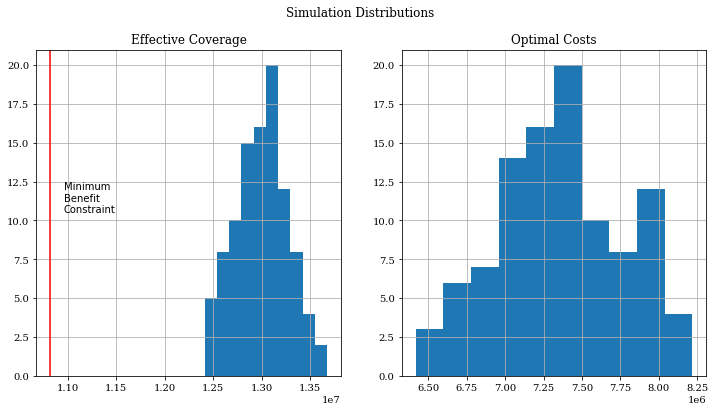

In [26]:

a.plot_opt_hist()

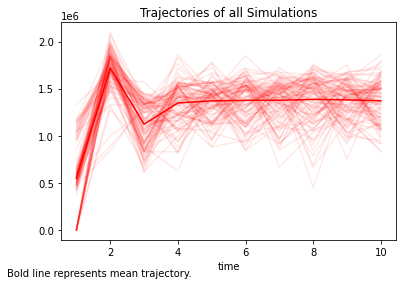

In [27]:
a.plot_sim_trajectories()


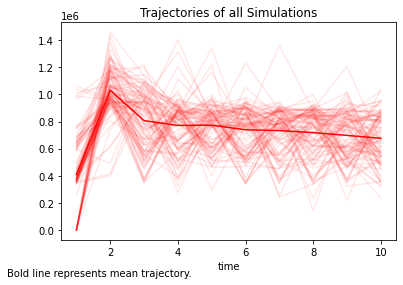

In [28]:
a.plot_sim_trajectories('costs')


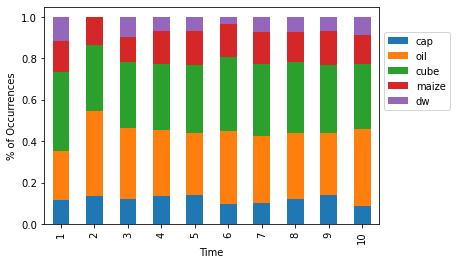

In [29]:
a.plot_intervention_stacked(intervention_group = ['cap','oil', 'cube', 'maize', 'dw'])